In [2]:
!pip install tensorflow matplotlib numpy pandas scikit-learn interpret
!pip install git+https://github.com/tensorflow/neural-structured-learning.git

  Using cached interpret-0.6.9-py3-none-any.whl.metadata (1.0 kB)
  Using cached interpret_core-0.6.9-py3-none-any.whl.metadata (2.8 kB)
  Using cached salib-1.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached aplr-10.8.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached dash-2.18.2-py3-none-any.whl.metadata (10 kB)
  Using cached dash_core_components-2.0.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached dash_html_components-2.0.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached dash_table-5.0.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached dash_cytoscape-1.0.2.tar.gz (4.0 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# 6. Verify GPU is available and configured correctly
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# 7. Display GPU info
!nvidia-smi

TensorFlow version: 2.18.0
GPU is available
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Fri Mar  7 08:50:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             48W /  400W |       5MiB /  40960MiB |      0%      Default |
|            

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from google.colab import files
uploaded = files.upload()

Saving final_dataset.xlsx to final_dataset.xlsx


Loading and preprocessing pavement data...
Missing values in each column:
STATE_CODE                 0
SHRP_ID                    0
YEAR                       0
CONSTRUCTION_NO            0
MAX_MEAN_DEPTH_1_8         0
ANL_KESAL_LTPP_LN_YR       0
TOTAL_ANN_PRECIP           0
FREEZE_INDEX_YR            0
MAX_ANN_TEMP_AVG           0
MAX_ANN_TEMP_DAYS          0
DAYS_ABOVE_32_C_YR         0
MR_MATL_TYPE               0
RES_MOD_AVG                0
REPR_THICKNESS          5362
dtype: int64
Found 49 outliers in target variable.
Applied winsorization to handle outliers.
Training set: (3541, 10), Validation set: (886, 10), Testing set: (1107, 10)

Training RF+EBM ensemble model...
Training Random Forest model...
RF training completed in 0.03 seconds

Training EBM model...
EBM training completed in 1815.23 seconds

Optimizing ensemble weights...
Optimal weights: RF=0.50, EBM=0.50

Model Performance:
RF - Train R²: 0.9712, Val R²: 0.9595
EBM - Train R²: 0.9632, Val R²: 0.9590
Ensemble - Train

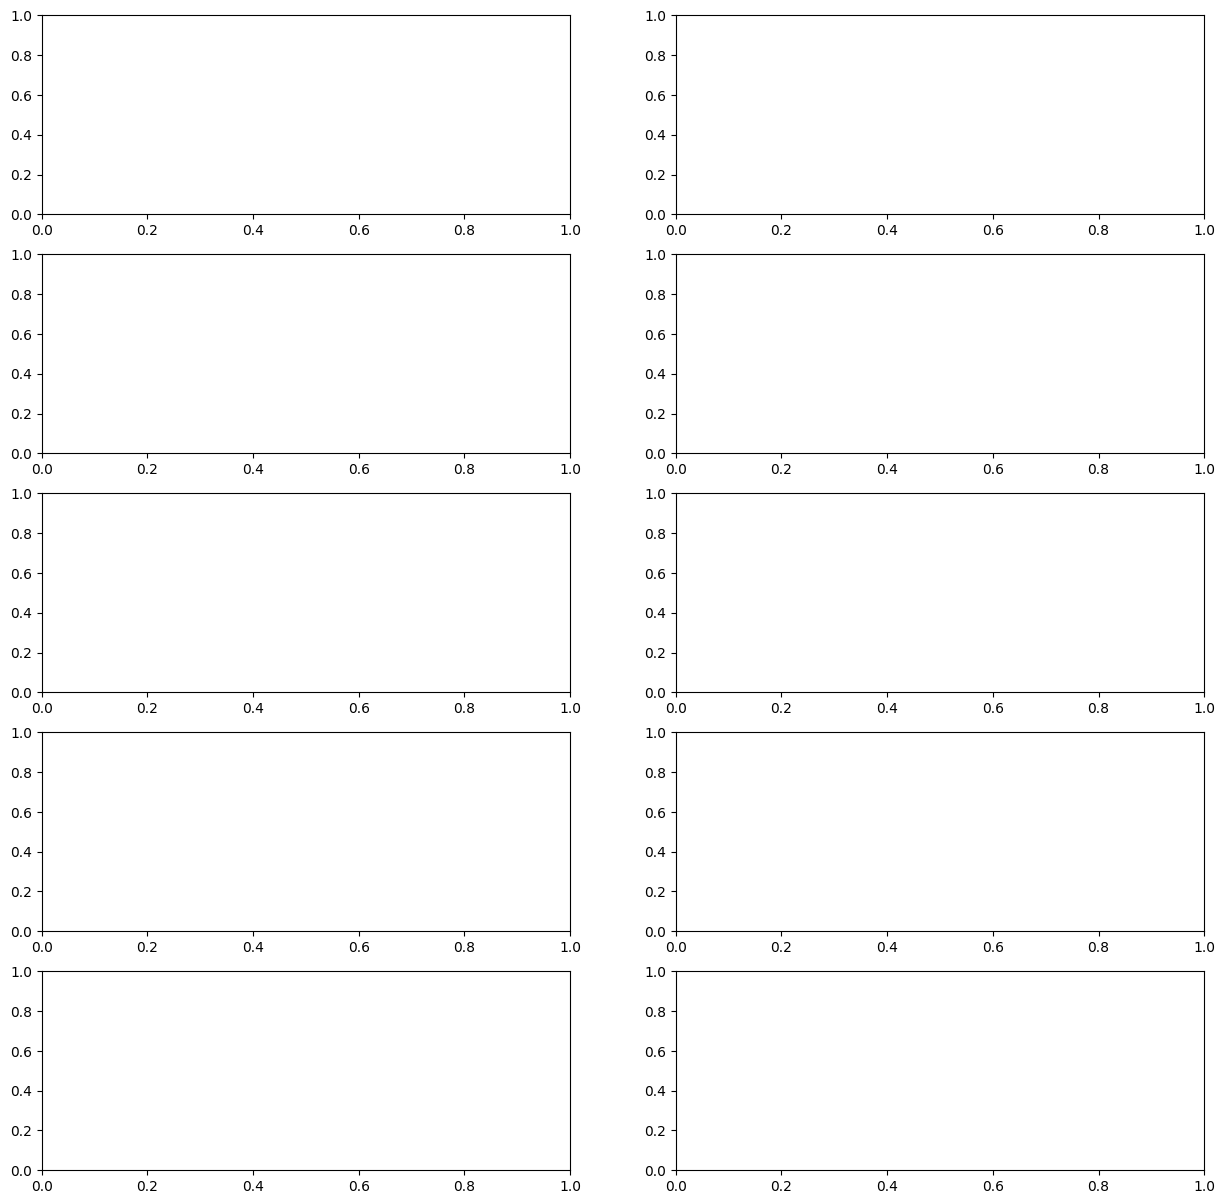

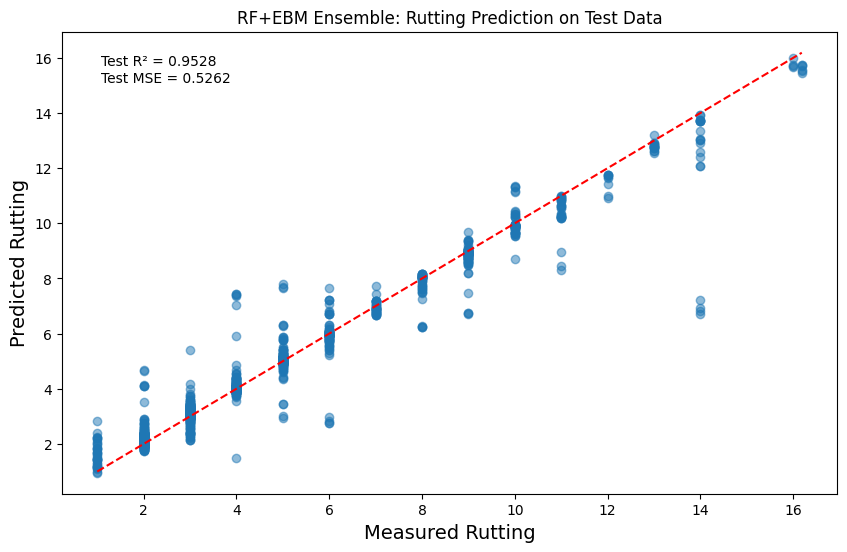

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Import interpret library for EBM
try:
    from interpret.glassbox import ExplainableBoostingRegressor
except ImportError:
    print("The 'interpret' package is not installed. Installing now...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "interpret"])
    from interpret.glassbox import ExplainableBoostingRegressor

# Set global random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Function to detect and handle outliers
def handle_outliers(X, y, method='clip', threshold=3):
    """Detect and handle outliers in the dataset."""
    if method == 'clip':
        # Clip outliers based on z-score
        z_scores = np.abs((y - np.mean(y)) / np.std(y))
        mask = z_scores < threshold
        return X[mask], y[mask]
    elif method == 'winsorize':
        # Winsorize the target variable
        y_mean, y_std = np.mean(y), np.std(y)
        lower_bound = y_mean - threshold * y_std
        upper_bound = y_mean + threshold * y_std
        y_winsorized = np.clip(y, lower_bound, upper_bound)
        return X, y_winsorized
    else:
        # No outlier handling
        return X, y

# Class to create an RF+EBM ensemble model
class RFEBMEnsemble:
    """Ensemble model combining Random Forest with Explainable Boosting Machine."""

    def __init__(self, rf_model=None, ebm_model=None, scaler=None, ensemble_weights=None):
        self.rf_model = rf_model
        self.ebm_model = ebm_model
        self.scaler = scaler
        self.ensemble_weights = ensemble_weights or [0.5, 0.5]  # Default to equal weighting

    def predict(self, X):
        # Scale features if scaler is provided
        if self.scaler is not None:
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X

        # Get predictions from each model
        rf_preds = self.rf_model.predict(X) if self.rf_model else None
        ebm_preds = self.ebm_model.predict(X) if self.ebm_model else None

        # Combine predictions
        if rf_preds is not None and ebm_preds is not None:
            return self.ensemble_weights[0] * rf_preds + self.ensemble_weights[1] * ebm_preds
        elif rf_preds is not None:
            return rf_preds
        elif ebm_preds is not None:
            return ebm_preds
        else:
            raise ValueError("No models available for prediction")

# Function to train the EBM model
def train_ebm(X_train, y_train, feature_names=None, params=None):
    """Train an Explainable Boosting Machine model."""
    start_time = time.time()

    # Define default parameters based on previous best EBM model
    if params is None:
        params = {
            'max_rounds': 5000,
            'interactions': 20,
            'max_bins': 512,
            'outer_bags': 32,
            'inner_bags': 4,
            'learning_rate': 0.005,
            'min_samples_leaf': 2,
            'validation_size': 0.2,
            'random_state': SEED
        }

    # Create and train EBM model
    ebm = ExplainableBoostingRegressor(
        max_rounds=params['max_rounds'],
        interactions=params['interactions'],
        max_bins=params['max_bins'],
        outer_bags=params['outer_bags'],
        inner_bags=params['inner_bags'],
        learning_rate=params['learning_rate'],
        min_samples_leaf=params['min_samples_leaf'],
        validation_size=params['validation_size'],
        random_state=params['random_state'],
        feature_names=feature_names
    )

    ebm.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"EBM training completed in {training_time:.2f} seconds")

    return ebm

# Function to train the RF model
def train_rf(X_train, y_train, params=None):
    """Train a Random Forest model."""
    start_time = time.time()

    # Define default parameters based on previous best RF model
    if params is None:
        params = {
            'n_estimators': 5,  # Original optimal value from previous analysis
            'max_depth': 22,
            'max_features': 8,
            'min_samples_leaf': 4,
            'random_state': SEED,
            'n_jobs': -1  # Use all available cores
        }

    # Create and train RF model
    rf = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        max_features=params['max_features'] if 'max_features' in params else 'sqrt',
        min_samples_leaf=params['min_samples_leaf'],
        random_state=params['random_state'],
        n_jobs=params['n_jobs']
    )

    rf.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"RF training completed in {training_time:.2f} seconds")

    return rf

# Function to train an ensemble of RF and EBM
def train_rf_ebm_ensemble(X_train, y_train, X_val, y_val, feature_names=None,
                           rf_params=None, ebm_params=None, optimize_weights=True):
    """Train an ensemble of RF and EBM models."""
    # Handle outliers
    X_train_clean, y_train_clean = handle_outliers(X_train, y_train, method='winsorize')

    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_clean)
    X_val_scaled = scaler.transform(X_val)

    # Train RF model
    print("Training Random Forest model...")
    rf_model = train_rf(X_train_clean, y_train_clean, rf_params)

    # Train EBM model
    print("\nTraining EBM model...")
    ebm_model = train_ebm(X_train_clean, y_train_clean, feature_names, ebm_params)

    # Get predictions from each model
    rf_preds_train = rf_model.predict(X_train_clean)
    rf_preds_val = rf_model.predict(X_val)
    ebm_preds_train = ebm_model.predict(X_train_clean)
    ebm_preds_val = ebm_model.predict(X_val)

    # Determine optimal ensemble weights if requested
    if optimize_weights:
        print("\nOptimizing ensemble weights...")
        best_r2 = -np.inf
        best_weights = [0.5, 0.5]

        for w1 in np.linspace(0, 1, 21):  # Test weights from 0 to 1 in 0.05 increments
            w2 = 1 - w1
            ensemble_preds_val = w1 * rf_preds_val + w2 * ebm_preds_val
            r2 = r2_score(y_val, ensemble_preds_val)

            if r2 > best_r2:
                best_r2 = r2
                best_weights = [w1, w2]

        print(f"Optimal weights: RF={best_weights[0]:.2f}, EBM={best_weights[1]:.2f}")
        ensemble_weights = best_weights
    else:
        ensemble_weights = [0.5, 0.5]

    # Create and evaluate ensemble model
    ensemble = RFEBMEnsemble(rf_model, ebm_model, scaler, ensemble_weights)

    ensemble_preds_train = ensemble.predict(X_train_clean)
    ensemble_preds_val = ensemble.predict(X_val)

    # Calculate metrics
    rf_train_r2 = r2_score(y_train_clean, rf_preds_train)
    rf_val_r2 = r2_score(y_val, rf_preds_val)
    ebm_train_r2 = r2_score(y_train_clean, ebm_preds_train)
    ebm_val_r2 = r2_score(y_val, ebm_preds_val)
    ensemble_train_r2 = r2_score(y_train_clean, ensemble_preds_train)
    ensemble_val_r2 = r2_score(y_val, ensemble_preds_val)

    rf_train_mse = mean_squared_error(y_train_clean, rf_preds_train)
    rf_val_mse = mean_squared_error(y_val, rf_preds_val)
    ebm_train_mse = mean_squared_error(y_train_clean, ebm_preds_train)
    ebm_val_mse = mean_squared_error(y_val, ebm_preds_val)
    ensemble_train_mse = mean_squared_error(y_train_clean, ensemble_preds_train)
    ensemble_val_mse = mean_squared_error(y_val, ensemble_preds_val)

    print("\nModel Performance:")
    print(f"RF - Train R²: {rf_train_r2:.4f}, Val R²: {rf_val_r2:.4f}")
    print(f"EBM - Train R²: {ebm_train_r2:.4f}, Val R²: {ebm_val_r2:.4f}")
    print(f"Ensemble - Train R²: {ensemble_train_r2:.4f}, Val R²: {ensemble_val_r2:.4f}")
    print(f"RF - Train MSE: {rf_train_mse:.4f}, Val MSE: {rf_val_mse:.4f}")
    print(f"EBM - Train MSE: {ebm_train_mse:.4f}, Val MSE: {ebm_val_mse:.4f}")
    print(f"Ensemble - Train MSE: {ensemble_train_mse:.4f}, Val MSE: {ensemble_val_mse:.4f}")

    return {
        'ensemble': ensemble,
        'rf_model': rf_model,
        'ebm_model': ebm_model,
        'scaler': scaler,
        'ensemble_weights': ensemble_weights,
        'metrics': {
            'rf': {'train_r2': rf_train_r2, 'val_r2': rf_val_r2,
                   'train_mse': rf_train_mse, 'val_mse': rf_val_mse},
            'ebm': {'train_r2': ebm_train_r2, 'val_r2': ebm_val_r2,
                   'train_mse': ebm_train_mse, 'val_mse': ebm_val_mse},
            'ensemble': {'train_r2': ensemble_train_r2, 'val_r2': ensemble_val_r2,
                         'train_mse': ensemble_train_mse, 'val_mse': ensemble_val_mse}
        }
    }

# Function to plot EBM feature functions
def plot_ebm_feature_functions(ebm_model, feature_names=None, top_n=10, figsize=(15, 15)):
    """Plot the global feature functions learned by the EBM model."""
    global_exp = ebm_model.explain_global()

    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(len(global_exp.feature_names))]

    # Get feature importance scores
    importances = global_exp.data()['scores']
    indices = np.argsort(importances)[::-1]

    # Select top n features
    top_indices = indices[:min(top_n, len(indices))]

    rows = (len(top_indices) + 1) // 2
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=figsize)
    axes = axes.flatten()

    for i, idx in enumerate(top_indices):
        if i >= len(axes):
            break

        feature_name = feature_names[idx] if idx < len(feature_names) else global_exp.feature_names[idx]

        # Get data for this feature
        data = global_exp.data(idx)

        # Plot feature function
        axes[i].plot(data['names'], data['scores'])
        axes[i].set_title(f"{feature_name} (Importance: {importances[idx]:.4f})")
        axes[i].set_xlabel(feature_name)
        axes[i].set_ylabel("Contribution to prediction")
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    return fig

# Function to plot EBM interaction effects
def plot_ebm_interactions(ebm_model, feature_names=None, top_n=5, figsize=(15, 15)):
    """Plot the most important interaction effects learned by the EBM model."""
    try:
        # Get interaction information
        interactions = ebm_model.explain_global().data(key='interaction_idx')
        if not interactions or len(interactions) == 0:
            print("No interactions found in the EBM model.")
            return None

        # Get interaction rankings
        interaction_scores = []
        for i, idx_tuple in enumerate(interactions):
            score = np.abs(ebm_model.explain_global().data(key='interaction_scores')[i]).mean()
            interaction_scores.append((idx_tuple, score))

        # Sort by importance
        interaction_scores.sort(key=lambda x: x[1], reverse=True)

        # Select top n interactions
        top_interactions = interaction_scores[:min(top_n, len(interaction_scores))]

        rows = (len(top_interactions) + 1) // 2
        fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=figsize)
        if rows == 1 and len(top_interactions) == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        for i, ((idx1, idx2), score) in enumerate(top_interactions):
            if i >= len(axes):
                break

            # Get feature names
            if feature_names is not None:
                feature1_name = feature_names[idx1] if idx1 < len(feature_names) else f"Feature {idx1}"
                feature2_name = feature_names[idx2] if idx2 < len(feature_names) else f"Feature {idx2}"
            else:
                feature1_name = ebm_model.explain_global().feature_names[idx1]
                feature2_name = ebm_model.explain_global().feature_names[idx2]

            # Get interaction data
            interaction_data = ebm_model.explain_global().data(key='interaction_values')[i]

            # Create heatmap
            im = axes[i].imshow(interaction_data, cmap='coolwarm', aspect='auto')
            axes[i].set_title(f"{feature1_name} × {feature2_name} (Score: {score:.4f})")
            axes[i].set_xlabel(feature1_name)
            axes[i].set_ylabel(feature2_name)

            # Add colorbar
            plt.colorbar(im, ax=axes[i])

        # Hide any unused subplots
        for j in range(i+1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        return fig

    except Exception as e:
        print(f"Error plotting interactions: {e}")
        return None

# Function to run the complete RF+EBM ensemble analysis
def run_rf_ebm_ensemble(data_path='final_dataset.xlsx'):
    """Run the complete RF+EBM ensemble analysis on pavement data."""
    print("Loading and preprocessing pavement data...")

    # Load data
    try:
        data = pd.read_excel(data_path)
    except:
        # For Google Colab, may need to upload the file first
        from google.colab import files
        uploaded = files.upload()
        data = pd.read_excel(list(uploaded.keys())[0])

    # Drop any unnamed columns if they exist
    unnamed_cols = [col for col in data.columns if 'Unnamed' in col]
    if unnamed_cols:
        data.drop(unnamed_cols, inplace=True, axis=1)

    # Remove duplicates
    data.drop_duplicates(inplace=True)

    # Check for missing values
    print("Missing values in each column:")
    print(data.isnull().sum())

    # Fill missing values robustly
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            if data[col].dtype in [np.float64, np.int64]:
                # Use median for numerical columns to be robust to outliers
                data[col].fillna(data[col].median(), inplace=True)
            else:
                # Use mode for categorical columns
                data[col].fillna(data[col].mode()[0], inplace=True)

    # Define features and target
    feature_names = [
        'CONSTRUCTION_NO',
        'ANL_KESAL_LTPP_LN_YR',
        'TOTAL_ANN_PRECIP',
        'FREEZE_INDEX_YR',
        'MAX_ANN_TEMP_AVG',
        'MAX_ANN_TEMP_DAYS',
        'DAYS_ABOVE_32_C_YR',
        'MR_MATL_TYPE',
        'RES_MOD_AVG',
        'REPR_THICKNESS'
    ]

    X = data[feature_names].values
    y = data['MAX_MEAN_DEPTH_1_8'].values

    # Check for and handle outliers in target variable
    z_scores = np.abs((y - np.mean(y)) / np.std(y))
    outliers = z_scores > 3
    if np.sum(outliers) > 0:
        print(f"Found {np.sum(outliers)} outliers in target variable.")
        # Use winsorization rather than removal to retain data
        y_mean, y_std = np.mean(y), np.std(y)
        lower_bound = y_mean - 3 * y_std
        upper_bound = y_mean + 3 * y_std
        y = np.clip(y, lower_bound, upper_bound)
        print("Applied winsorization to handle outliers.")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Further split training data to have a validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

    print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Testing set: {X_test.shape}")

    # Define model parameters
    rf_params = {
        'n_estimators': 5,  # Original optimal value from previous RF
        'max_depth': 22,
        'max_features': 8,
        'min_samples_leaf': 4,
        'random_state': SEED,
        'n_jobs': -1
    }

    ebm_params = {
        'max_rounds': 5000,
        'interactions': 20,
        'max_bins': 512,
        'outer_bags': 32,
        'inner_bags': 4,
        'learning_rate': 0.005,
        'min_samples_leaf': 2,
        'validation_size': 0.2,
        'random_state': SEED
    }

    # Train ensemble model
    print("\nTraining RF+EBM ensemble model...")
    results = train_rf_ebm_ensemble(
        X_train, y_train, X_val, y_val, feature_names,
        rf_params=rf_params, ebm_params=ebm_params,
        optimize_weights=True
    )

    # Extract models and metrics
    ensemble = results['ensemble']
    rf_model = results['rf_model']
    ebm_model = results['ebm_model']
    metrics = results['metrics']

    # Evaluate on test set
    y_pred_test = ensemble.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)

    print("\nEnsemble model performance on test set:")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test R²: {test_r2:.4f}")

    # Plot EBM feature functions
    print("\nPlotting EBM feature functions...")
    try:
        fig_features = plot_ebm_feature_functions(ebm_model, feature_names)
        plt.show()
    except Exception as e:
        print(f"Error plotting feature functions: {e}")

    # Plot EBM interaction effects
    print("\nPlotting EBM interaction effects...")
    try:
        fig_interactions = plot_ebm_interactions(ebm_model, feature_names)
        if fig_interactions:
            plt.show()
    except Exception as e:
        print(f"Error plotting interaction effects: {e}")

    # Plot predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Measured Rutting', fontsize=14)
    plt.ylabel('Predicted Rutting', fontsize=14)
    plt.title('RF+EBM Ensemble: Rutting Prediction on Test Data')
    plt.text(0.05, 0.95, f'Test R² = {test_r2:.4f}\nTest MSE = {test_mse:.4f}',
             transform=plt.gca().transAxes, verticalalignment='top')
    plt.show()

    # Return models and metrics
    return {
        'ensemble': ensemble,
        'rf_model': rf_model,
        'ebm_model': ebm_model,
        'metrics': {**metrics, 'test': {'mse': test_mse, 'r2': test_r2}}
    }

# Run the RF+EBM ensemble analysis if executed directly
if __name__ == "__main__":
    results = run_rf_ebm_ensemble()